# 2 Audio Exploratory Data Analysis

In [1]:
# for audio files
import librosa
import librosa.display
import IPython.display as ipd

# data science essentials
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

## Notebook Summary

This notebook will explore the features of the audio files and determine how the train set will be preprocessed for modelling. Specifically, the EDA will explore the MFCC and the spectrograms, and consider which features to use for the model.

In general, all of the audio files provided by IMDA have a sample-rate of 16,000 Hz. Librosa library automatically changes everything to a sampling rate of 22,050 Hz. Hence, I have chosen to keep the default Librosa Sampling Rate as the entire API is designed and built upon that sampling rate. Although the higher the sampling rate, the higher the definition of detail, it does not really matter for this case since the recordings are done in a controlled environment.

## Table of Content

- [Basic EDA](#Basic-EDA)
- [Outliers](#Examining-the-Outliers)
- [Soundwave of Each Label](#Examine-the-Soundwave-of-Each-Label)
- [Mel-Frequency Cepstral Coefficients and Deltas](#Visualing-the-Mel-Frequency-Cepstral-Coefficients-(MFCC))
- [Mel-Spectrograms](#Visualising-Mel-Spectrograms)

In [2]:
# import train set
train_df = pd.read_csv("datasets/train.csv")

In [3]:
# examine dataframe
train_df.head()

,id,filepath,duration,class_label
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water
3,10210062,./assets/audio_train/10210062_flowers.wav,0.399229,flowers
4,10210066,./assets/audio_train/10210066_apples.wav,0.524354,apples


In [4]:
# check for null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1049 non-null   int64  
 1   filepath     1049 non-null   object 
 2   duration     1049 non-null   float64
 3   class_label  1049 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 32.9+ KB


In [5]:
# get labels

labels = train_df['class_label'].unique().tolist()
labels.sort()
labels

['apples', 'father', 'flowers', 'water', 'worker']

### Basic EDA

Text(0.5, 0, 'Number of Files')

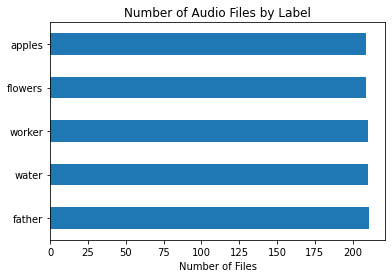

In [6]:
train_df['class_label'].value_counts().plot(kind='barh')
plt.title('Number of Audio Files by Label')
plt.xlabel('Number of Files')

In [7]:
train_df['class_label'].value_counts()

father     211
water      210
worker     210
flowers    209
apples     209
Name: class_label, dtype: int64

There are almost the same number of audio files per class. This is excellent as it will avoid training the model to be more or less biased towards certain classes.

In [8]:
train_df.groupby('class_label').describe()['duration']

,count,mean,std,min,25%,50%,75%,max
class_label,,,,,,,,
apples,209.0,0.501645,0.090702,0.336689,0.432880,0.490204,0.548707,0.802449
father,211.0,0.422358,0.095542,0.245261,0.358889,0.404535,0.472562,0.767664
flowers,209.0,0.541884,0.107630,0.322132,0.471020,0.527256,0.595692,0.965261
water,210.0,0.426814,0.098384,0.212698,0.362732,0.410839,0.475431,0.842902
worker,210.0,0.488509,0.073574,0.345351,0.436995,0.483311,0.530805,0.767755


The average length of the audio files are quite similar, at about 0.4-0.5 seconds.

Even though all the words have two syllables, the time it takes to pronounce the words can go as quick as 0.21 seconds for `water` and as long as almost 1 second for `flowers`. 

There is no obvious and consistent trend which separates the different words.

Text(0.5, 0, 'label')

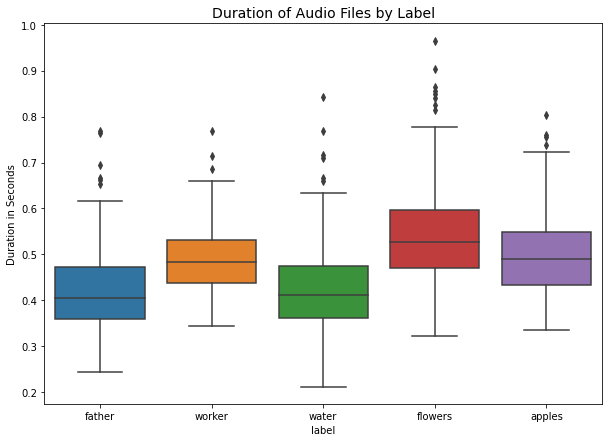

In [9]:
plt.figure(figsize=(10,7))
sns.boxplot(x= 'class_label', y ='duration', data=train_df)
plt.title('Duration of Audio Files by Label', size=14)
plt.ylabel('Duration in Seconds')
plt.xlabel('label')

In general, it seems like the word `flowers` are pronounced longer than the other words, followed by `apples`. Meanwhile, `father` and `water` seems to share the same distribution in terms of duration. 

### Examining the Outliers

Below, I examine the top 3 longest audio clips of each class. This is to determine whether the audio files require additional processing or whether it shoud be deleted as it may affect predictions.

In [10]:
# for each label
for l in labels:
    # outliers being top 3 longest audio clips
    outliers = train_df[train_df['class_label'] == l].sort_values(by = 'duration', ascending=False)[:3]
    # print label
    print(l)
    # generate audio playback interface
    for f in outliers['filepath']:
        audio, sr = librosa.load(f)
        ipd.display(ipd.Audio(f))
        

apples


father


flowers


water


worker


After listening to the clips, it seems like all of them just articulated clearer and slower than the majority of the speakers. It is not uncommon for people to speak at that pace, the model should include these audio data in order to be as inclusive as possible. All of the outliers will be kept.

### Examine the Soundwave of Each Label

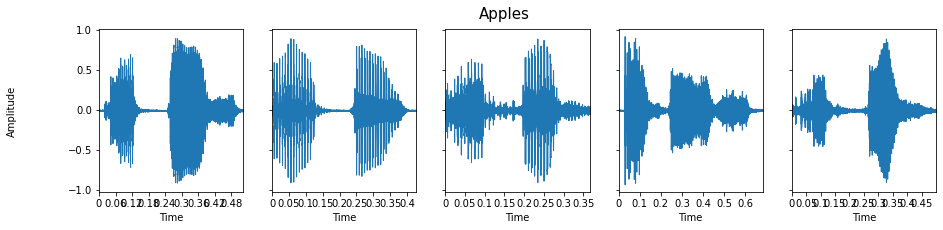

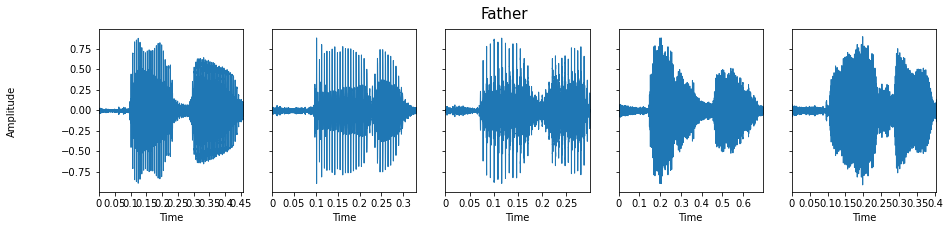

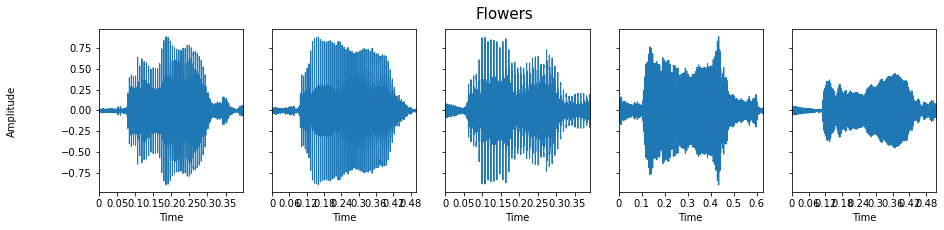

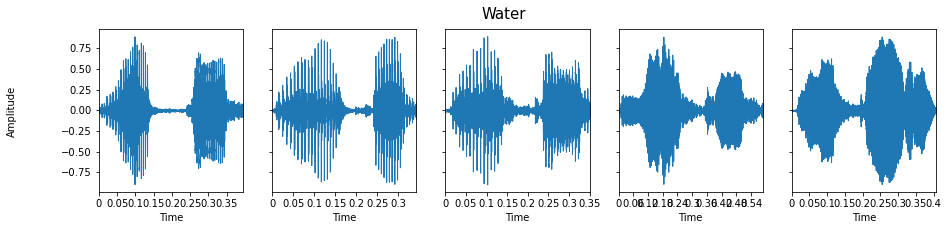

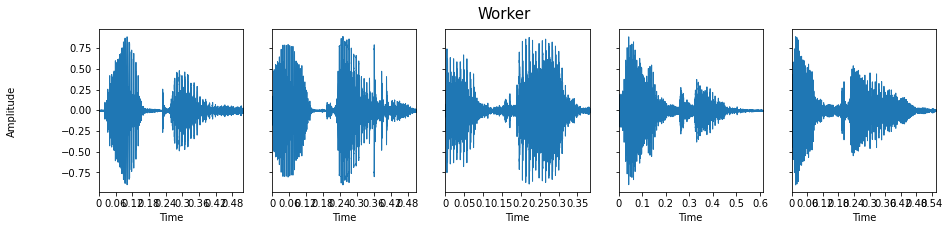

In [11]:
for l in labels:
    filepaths = train_df[train_df['class_label'] == l][:5]['filepath'].values
    
    # create one set of subplots for each class
    fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(15,3), sharey=True)
    ax = ax.ravel()
    fig.suptitle(l.capitalize(), size=15)
    fig.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical')
    
    # plot sound wave in each subplot
    for n, f in enumerate(filepaths):
        audio, sr = librosa.load(f)
        librosa.display.waveplot(audio, sr=sr, ax=ax[n])
    

The sound wave for `father` and `flowers` have similar beginning while the words `water`, `apples`, and `worker` have distinct breaks between them.

It might still be difficult to classify the different audio classes based on raw sound waves. For example, some people might place emphasis on the second syllable while some place their stress on the first syllable. Moreover, the duration of each recording also differs. In order to better classify them, they need to be further processed to extract more distinct features.

### Visualing the Mel-Frequency Cepstral Coefficients (MFCC)

MFCCs are known to be good at pattern recognition concerning human voice. They are widely used in speech recognition and speaker identification$^{1}$. It is a good way to identify the formants ("identity" of an audio) which could be helpful in my multi classification problem.


$^{1}$ http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.307.2786&rep=rep1&type=pdf

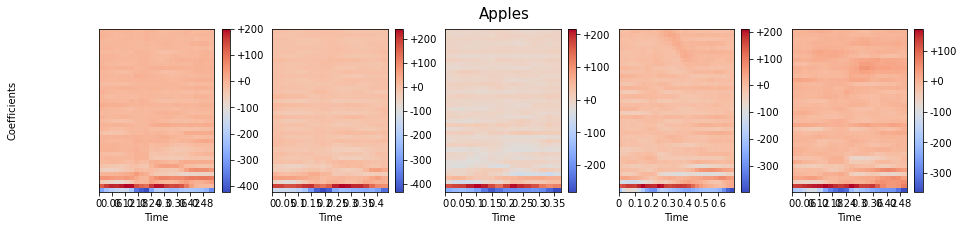

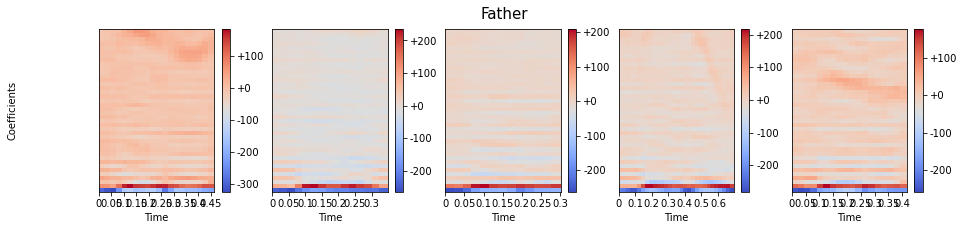

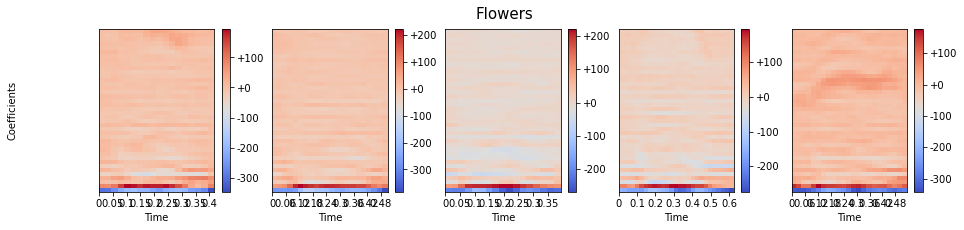

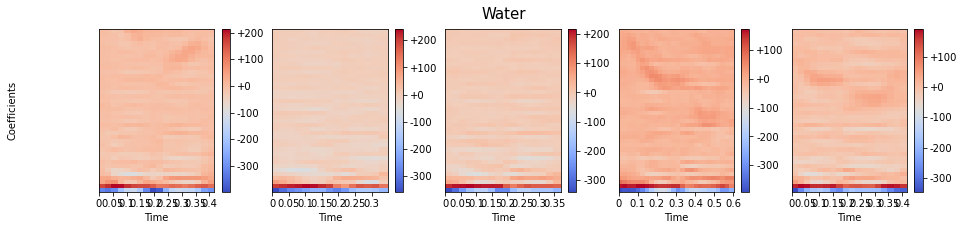

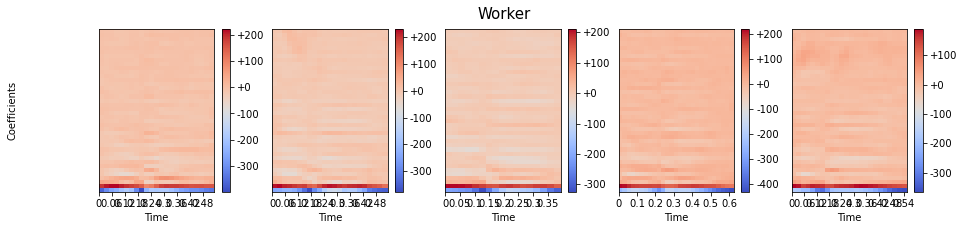

In [12]:
for l in labels:
    # retrieve the file paths
    filepaths = train_df[train_df['class_label'] == l][:5]['filepath'].values
    
    # create one set of subplots for each class
    fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(15,3), sharey=True)
    ax = ax.ravel()
    fig.suptitle(l.capitalize(), size=15)
    fig.text(0.04, 0.5, 'Coefficients', va='center', rotation='vertical')
    
    # plot the mfcc 
    for n, f in enumerate(filepaths):
        audio, sr = librosa.load(f)
        mfcc = librosa.feature.mfcc(audio, sr = sr, n_mfcc=40)
        spec = librosa.display.specshow(mfcc, ax=ax[n], x_axis = 'time')
        fig.colorbar(spec, format='%+2.f', ax=ax[n])

As many research paper have demonstrated, the most distinguishing feature usually lies in the first few coefficient. Evidently, the first two coefficient seems to have the most intensity, giving us red and blue grids. These are the coefficients which provides the most important information.

Across the different speakers, the first few coefficient to have some pattern across the same label. In other words, if we examine the first coefficient for `worker`, we notice the white and blue spots have some kind of consistency. If combined with the coefficients, the MFCC will make a good feature to distinguish the different classes. For such a complex data structure, the neural network should be suitable for processing all of these.

However, I think the graph itself will not do well in a Convolutional Neural Network as they look way too similar. An FNN or RNN would be the most efficient way to process the data rather than through such images.

## Visualising MFCC Delta and Delta2

The MFCC Delta allows us to examine the change over time for each coefficient. This is useful especially for audio with varying sounds, it allows us to better understand the behaviour over time. On the other hand, MFCC Delta 2 gives us the rate of that change. Delta 2 is also helpful for us to understand how the change in the feature change over time.

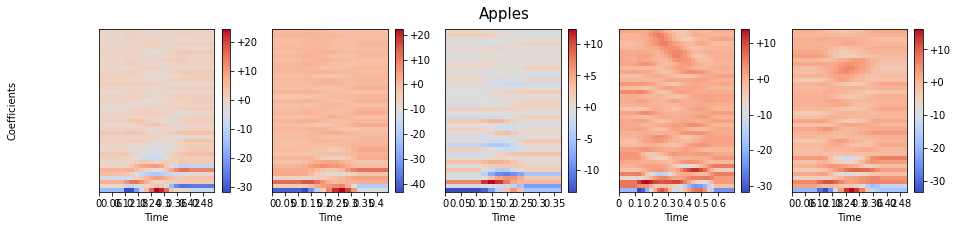

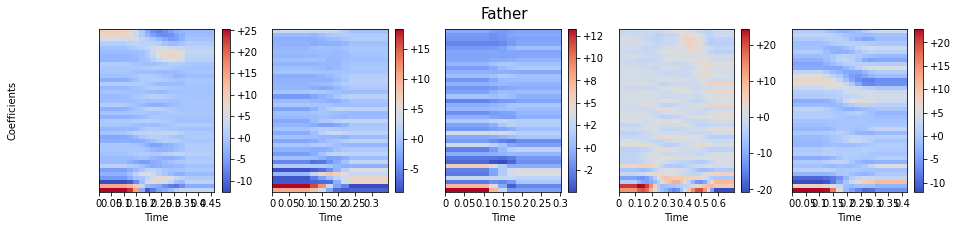

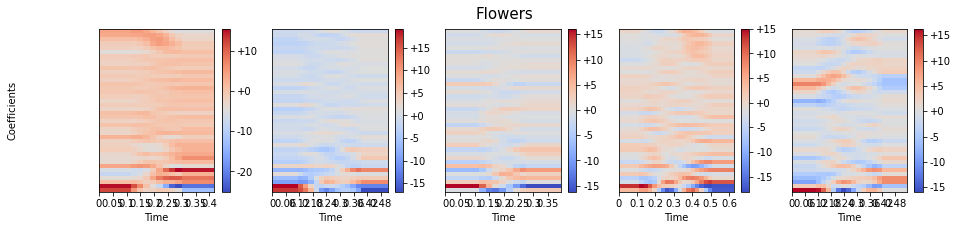

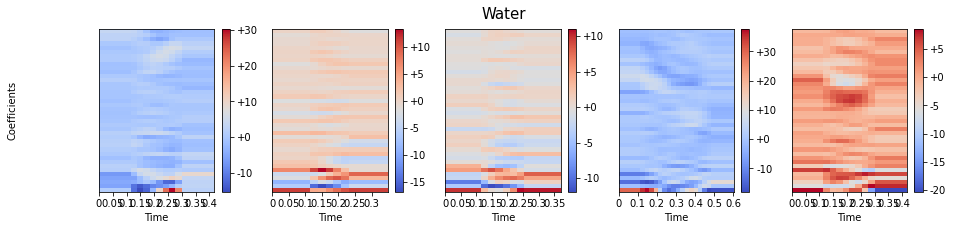

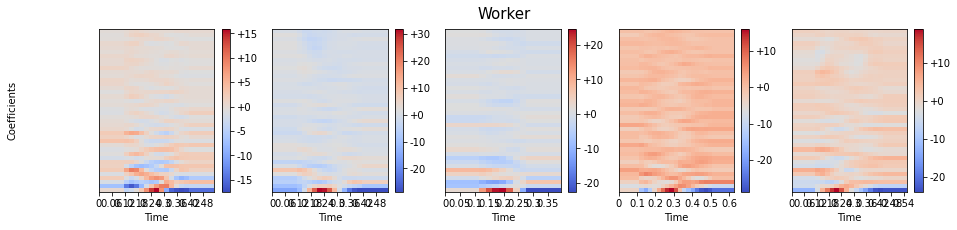

In [13]:
for l in labels:
    # get the file path
    filepaths = train_df[train_df['class_label'] == l][:5]['filepath'].values
    
    # create one set of subplots for each class
    fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(15,3), sharey=True)
    ax = ax.ravel()
    fig.suptitle(l.capitalize(), size=15)
    fig.text(0.04, 0.5, 'Coefficients', va='center', rotation='vertical')
    
    # plot the MFCC Delta 
    for n, f in enumerate(filepaths):
        audio, sr = librosa.load(f)
        mfcc = librosa.feature.mfcc(audio, sr = sr, n_mfcc=40)
        # delta 1
        delta = librosa.feature.delta(mfcc)
        spec = librosa.display.specshow(delta, ax=ax[n], x_axis = 'time')
        fig.colorbar(spec, format='%+2.f', ax=ax[n])

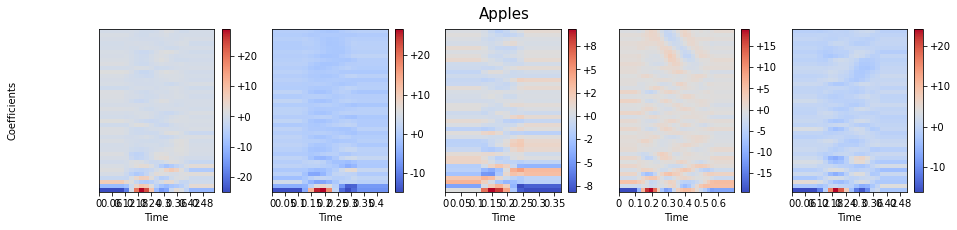

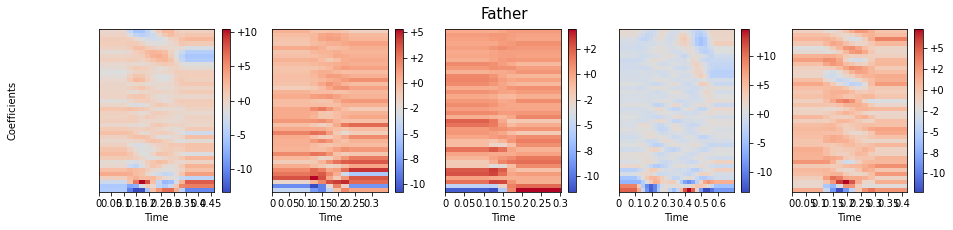

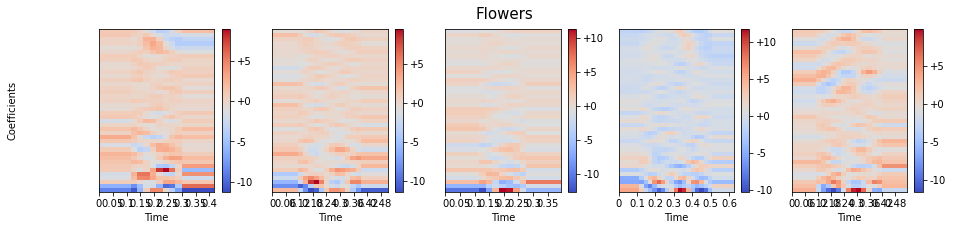

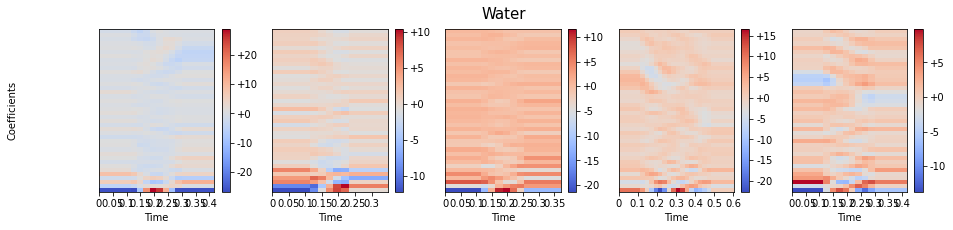

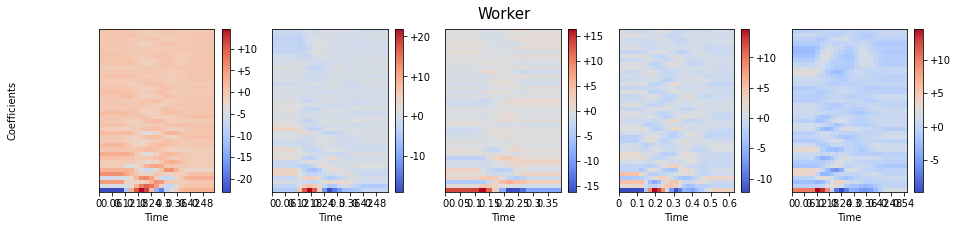

In [14]:
for l in labels:
    # get file path
    filepaths = train_df[train_df['class_label'] == l][:5]['filepath'].values
    
    # create one set of subplots for each class
    fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(15,3), sharey=True)
    ax = ax.ravel()
    fig.suptitle(l.capitalize(), size=15)
    fig.text(0.04, 0.5, 'Coefficients', va='center', rotation='vertical')
    
    # plot the melspectrogram of 
    for n, f in enumerate(filepaths):
        audio, sr = librosa.load(f)
        mfcc = librosa.feature.mfcc(audio, sr = sr, n_mfcc=40)
        # get delta 2
        delta2 = librosa.feature.delta(mfcc, order = 2)
        spec = librosa.display.specshow(delta2, ax=ax[n], x_axis = 'time')
        fig.colorbar(spec, format='%+2.f', ax=ax[n])

For both delta and delta2, it seems like there is no strong consitent pattern between each classes if we visualise it this way. However, delta and delta2 contains important features regarding the change over time. One way to utilise this is to combine delta and delta2 data together with the MFCC to create a dataset with larger dimension, allowing for more precise classification.

## Visualising Mel-Spectrograms

The mel-spectrograms are spectrograms which has been converted into mel-scaled frequency. It tells us the kind of frequencies and its intensity at a given time frame. Such visualisation might be possible for CNN classification.

**Mel-Spectrogram with 90 Mel-bands**

D:\Anaconda\envs\Capstone\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
D:\Anaconda\envs\Capstone\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


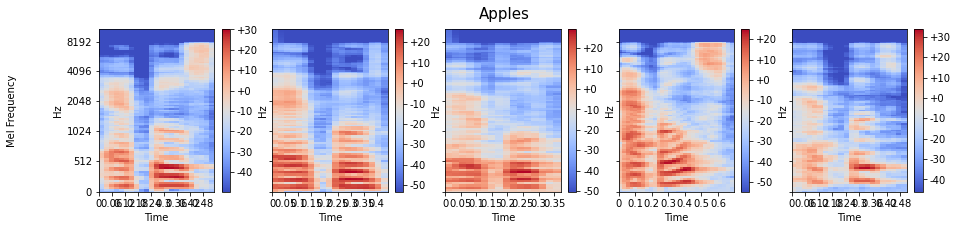

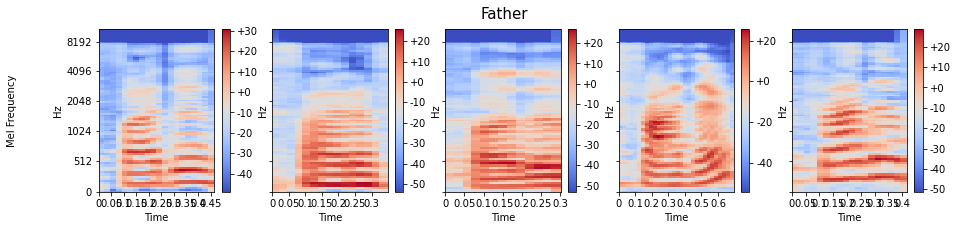

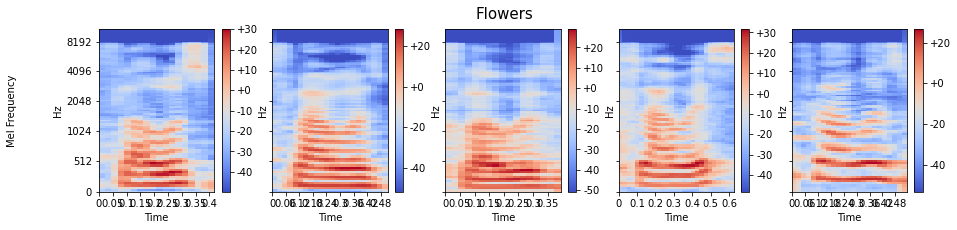

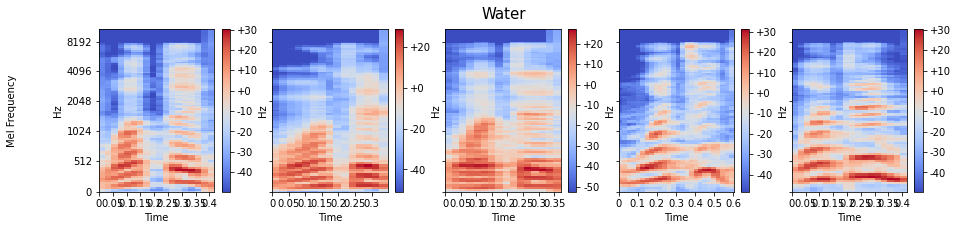

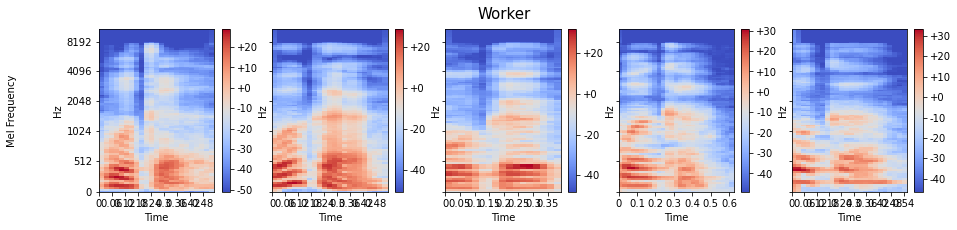

In [15]:
for l in labels:
    # get file path
    filepaths = train_df[train_df['class_label'] == l][:5]['filepath'].values
    
    # create one set of subplots for each class
    fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(15,3), sharey=True)
    ax = ax.ravel()
    fig.suptitle(l.capitalize(), size=15)
    fig.text(0.04, 0.5, 'Mel Frequency', va='center', rotation='vertical')
    
    # plot the melspectrogram
    for n, f in enumerate(filepaths):
        audio, sr = librosa.load(f)
        # 90 mel bands
        mel_spectrogram = librosa.feature.melspectrogram(audio, sr = sr, n_mels=90)
        # convert to log scale
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        mel_show = librosa.display.specshow(log_mel_spectrogram,sr = sr, ax=ax[n],x_axis = 'time', y_axis = 'mel')
        fig.colorbar(mel_show, format='%+2.f', ax=ax[n])

We can see some kind of consistency between different speakers pronouncing the same word. However, there are some graphs across different class which also look quite similar. Below, I will try with 20 mel-bands instead.

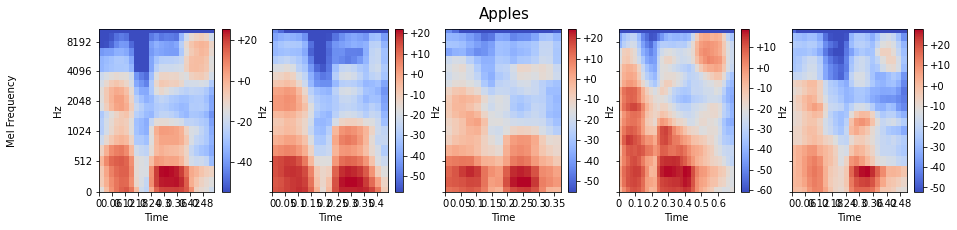

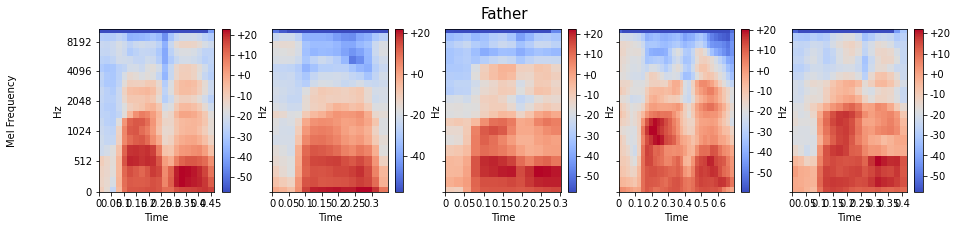

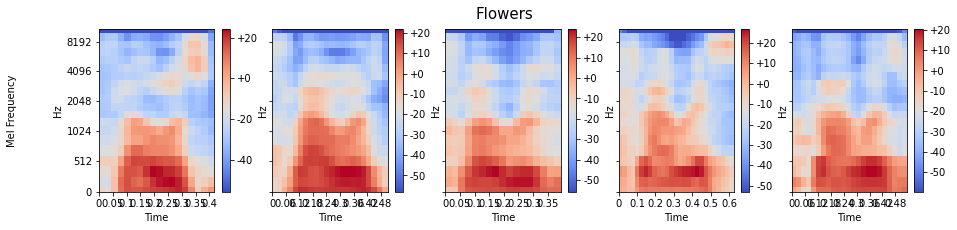

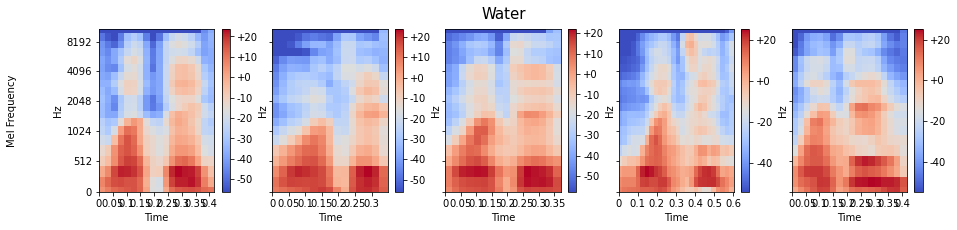

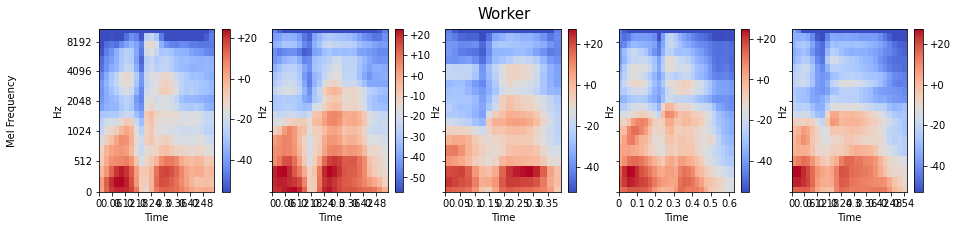

In [16]:
for l in labels:
    # get file path
    filepaths = train_df[train_df['class_label'] == l][:5]['filepath'].values
    
    # create one set of subplots for each class
    fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(15,3), sharey=True)
    ax = ax.ravel()
    fig.suptitle(l.capitalize(), size=15)
    fig.text(0.04, 0.5, 'Mel Frequency', va='center', rotation='vertical')
    
    # plot the melspectrogram 
    for n, f in enumerate(filepaths):
        audio, sr = librosa.load(f)
        # 20 mel bands
        mel_spectrogram = librosa.feature.melspectrogram(audio, sr = sr, n_mels=20)
        # log scale
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        mel_show = librosa.display.specshow(log_mel_spectrogram,sr = sr, ax=ax[n],x_axis = 'time', y_axis = 'mel')
        fig.colorbar(mel_show, format='%+2.f', ax=ax[n])

With 20 filter mel-bands, the features are more obvious. This can potentially be used for image classification using Convolutional Neural Network.

Click [here](./3%20Preprocessing%20and%20Modelling.ipynb) to go to the next workbook